<a href="https://colab.research.google.com/github/rokmr/Natural-Language-Processing/blob/main/n_grams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

******
This Notebook implements **bi-gram** and **tri-gram** at character level

 **Trigram: Need to be built**
******

# Data Preparation

In [11]:
import requests
url = "https://raw.githubusercontent.com/rokmr/Natural-Language-Processing/main/names.txt"
output_file = "names.txt"

response = requests.get(url)
with open(output_file, 'wb') as file:
    file.write(response.content)

words = open('/content/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [114]:
print(len(words))
print(min(len(w) for w in words))
print(max(len(w) for w in words))

32033
2
15


# Bi-gram

In [27]:
import torch
torch.__version__

'2.0.1+cu118'

In [33]:
N = torch.zeros((27, 27), dtype=torch.int32)  # 26  for alphabets and 1 for special char i.e., <S> and <E>

In [29]:
chars = sorted(list(set(''.join(words))))  # Creates sorted list of the unique characters occuring in the words
stoi = {s:i+1 for i,s in enumerate(chars)}  # Enum across all the chars to make string to int like a:1, b:2 and so on
stoi['.'] = 0   # indexing special char as indexed to zero better N matrix in further calculations
itos = {i:s for s,i in stoi.items()}   # int to string

## Counting Bi-gram

Now Creating Our N matrix

In [49]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1


### Visualizing Count Matrix : N

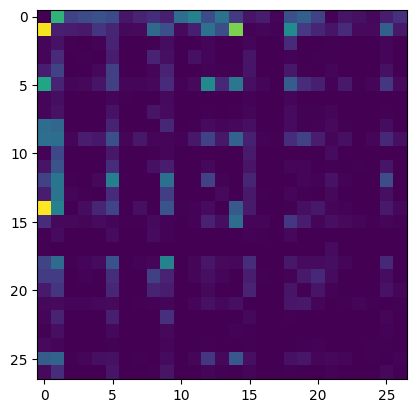

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N)

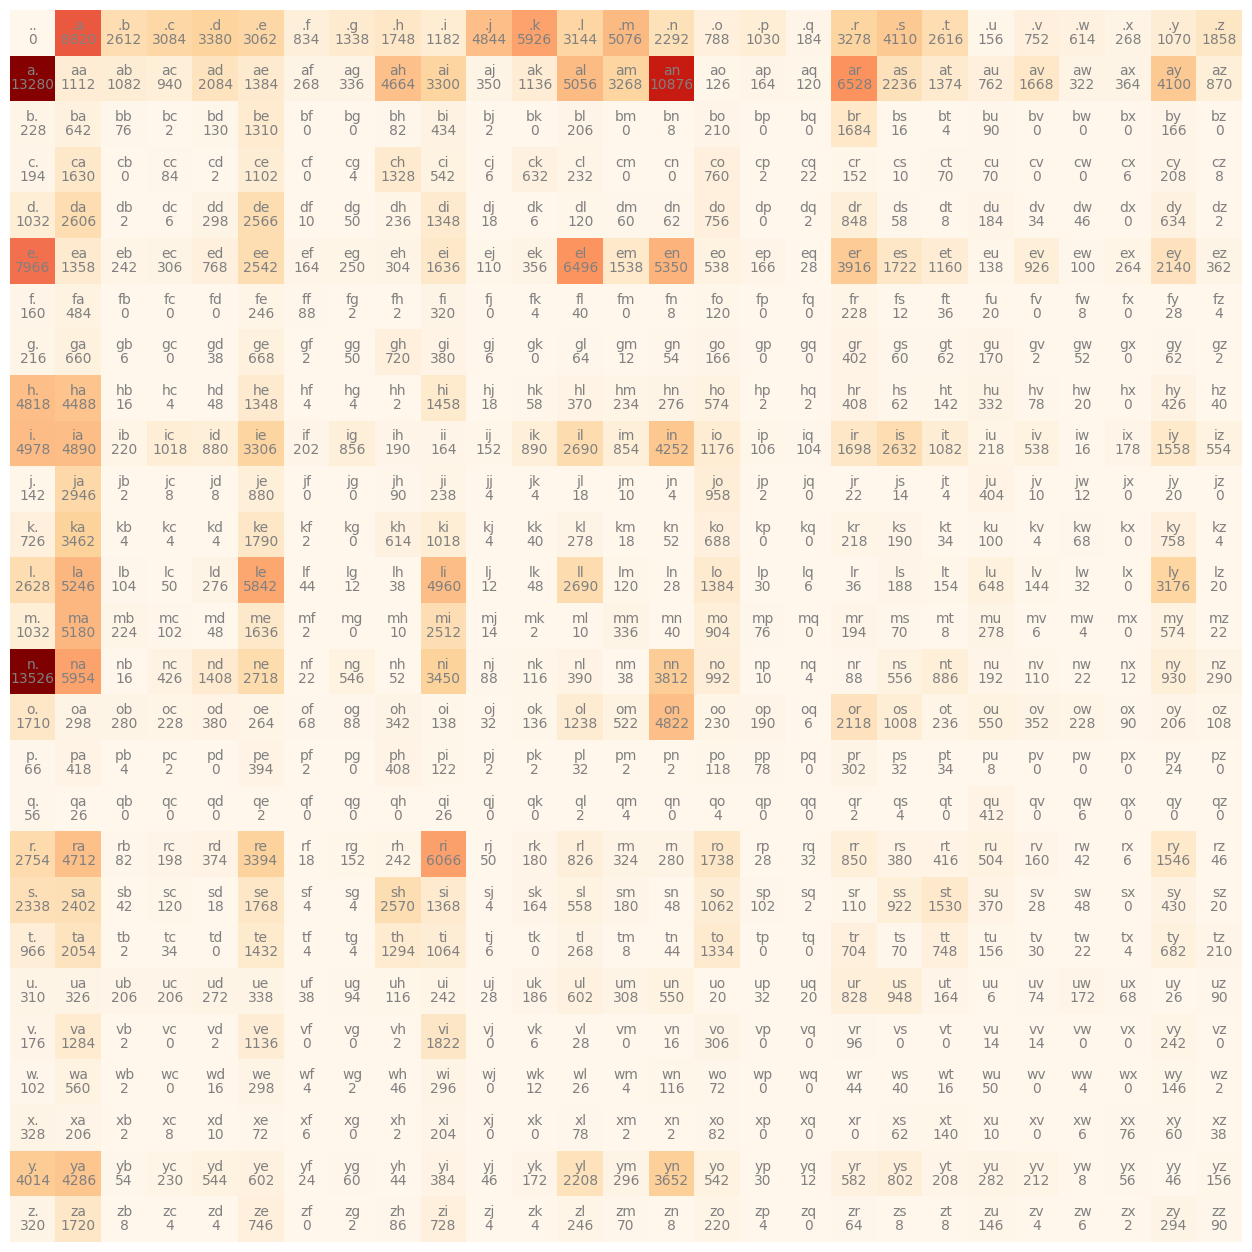

In [50]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='OrRd')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### Model

In [118]:
# Hyper Parameter
smoother =1    # This is for making model avoid the case for the prob 0 CASE.

# If somoother value is high then the model turns out to be uniform model
# Smooother is equivalent to adding regularization to the neural network (eta )
p = (N[0]+smoother).float()
print(p)
p = p / p.sum()
print(p)

tensor([1.0000e+00, 8.8210e+03, 2.6130e+03, 3.0850e+03, 3.3810e+03, 3.0630e+03,
        8.3500e+02, 1.3390e+03, 1.7490e+03, 1.1830e+03, 4.8450e+03, 5.9270e+03,
        3.1450e+03, 5.0770e+03, 2.2930e+03, 7.8900e+02, 1.0310e+03, 1.8500e+02,
        3.2790e+03, 4.1110e+03, 2.6170e+03, 1.5700e+02, 7.5300e+02, 6.1500e+02,
        2.6900e+02, 1.0710e+03, 1.8590e+03])
tensor([1.5602e-05, 1.3763e-01, 4.0769e-02, 4.8133e-02, 5.2751e-02, 4.7790e-02,
        1.3028e-02, 2.0892e-02, 2.7288e-02, 1.8458e-02, 7.5593e-02, 9.2475e-02,
        4.9069e-02, 7.9213e-02, 3.5776e-02, 1.2310e-02, 1.6086e-02, 2.8864e-03,
        5.1160e-02, 6.4141e-02, 4.0831e-02, 2.4496e-03, 1.1749e-02, 9.5954e-03,
        4.1970e-03, 1.6710e-02, 2.9005e-02])


In [119]:
print(torch.multinomial(p, num_samples=10, replacement=True))

# Drawing samples from the multinomial dis of p which we made at above
ix = torch.multinomial(p, num_samples=1, replacement=True).item()
itos[ix]

tensor([12,  7, 18, 18, 19, 20, 13, 13,  3,  8])


'j'

In [120]:
# Making a matrix as probabilistic
P = N.float()  # 27, 27
sum = P.sum(1, keepdim=True)   # 27,  1
P /= sum     # 27, 27
P.shape

torch.Size([27, 27])

### Inferance

In [121]:
# Generating word with the help of N (or P) matrix
for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

ka.
my.
jall.
naeryn.
te.


### Loss

* GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
* equivalent to maximizing the log likelihood (because log is monotonic)
* equivalent to minimizing the negative log likelihood
* equivalent to minimizing the average negative log likelihood

In [124]:
log_likelihood = 0.0
n = 0    # will count how many bigram being processed.

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]          # We want to maximize the likelihood i.e., product of probabilities
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')        # nll : negative log likelihood:We want to minimize it

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
2.454094171524048


##  Neural Network Bi-gram

### Data and Parameters

In [126]:
# create the a training  of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


In [128]:
# Encoding input(xs) as one hot vector
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()   # As NN requires float data type to feed in one hot or something similar
print(f"{xenc.shape=}")
xenc

xenc.shape=torch.Size([5, 27])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [141]:
W = torch.randn((27, 27))  # [5, 27] * [27, 1] -> [5, 27]
o = xenc @ W
print(f"{o.shape=}")
print(f"{o =}")

o.shape=torch.Size([5, 27])
o =tensor([[ 7.9784e-01, -5.2801e-01, -1.4389e-01, -1.3027e+00, -3.8180e-01,
          3.0520e-01,  2.6411e-01, -2.1175e-01, -1.9737e-02,  7.6548e-01,
         -2.2079e+00,  6.8712e-01,  6.8480e-01, -1.8277e+00,  1.9673e-01,
         -1.4372e-01, -2.3354e-01, -1.4345e+00, -3.4168e-01, -3.1629e-01,
         -1.1714e+00, -6.8367e-01, -1.4850e-01,  1.3606e-01,  2.0889e+00,
         -1.6929e+00,  1.5832e+00],
        [ 6.8011e-01, -2.4185e-01, -2.2595e-01, -1.3626e+00, -3.9615e-03,
          3.4823e+00, -6.0304e-02,  1.0366e+00,  9.0499e-01, -4.1274e-01,
          6.7449e-01, -7.3369e-02,  1.8420e+00, -3.4520e-01, -3.7003e-02,
          9.0595e-01,  1.6325e-01,  3.7594e-01, -1.7673e-01,  2.1075e-01,
          6.8271e-01,  5.1712e-01,  1.5948e+00,  9.4928e-01, -3.4417e-01,
         -1.6722e+00, -3.0861e-01],
        [ 2.4027e-01,  1.1727e+00,  3.6662e-01, -9.2613e-01,  2.2063e+00,
         -1.0576e+00,  1.0926e+00, -4.5395e-01,  2.6985e-03,  2.4021e+00,
         

In [142]:
# Converting to Probabilities
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0617, 0.0164, 0.0241, 0.0076, 0.0190, 0.0377, 0.0362, 0.0225, 0.0273,
         0.0598, 0.0031, 0.0553, 0.0551, 0.0045, 0.0338, 0.0241, 0.0220, 0.0066,
         0.0198, 0.0203, 0.0086, 0.0140, 0.0240, 0.0318, 0.2245, 0.0051, 0.1354],
        [0.0263, 0.0105, 0.0106, 0.0034, 0.0133, 0.4333, 0.0125, 0.0376, 0.0329,
         0.0088, 0.0261, 0.0124, 0.0840, 0.0094, 0.0128, 0.0329, 0.0157, 0.0194,
         0.0112, 0.0164, 0.0264, 0.0223, 0.0656, 0.0344, 0.0094, 0.0025, 0.0098],
        [0.0195, 0.0496, 0.0222, 0.0061, 0.1394, 0.0053, 0.0458, 0.0098, 0.0154,
         0.1696, 0.0113, 0.0126, 0.0520, 0.0182, 0.0067, 0.0084, 0.0496, 0.1175,
         0.0108, 0.0240, 0.0647, 0.0379, 0.0257, 0.0197, 0.0292, 0.0008, 0.0283],
        [0.0195, 0.0496, 0.0222, 0.0061, 0.1394, 0.0053, 0.0458, 0.0098, 0.0154,
         0.1696, 0.0113, 0.0126, 0.0520, 0.0182, 0.0067, 0.0084, 0.0496, 0.1175,
         0.0108, 0.0240, 0.0647, 0.0379, 0.0257, 0.0197, 0.0292, 0.0008, 0.0283],
        [0.0408, 0.1184,

In [146]:
probs[0].sum()

tensor(1.)

### Summary

In [149]:
# Input Example
print(f"{xs = }")   #Input
print(f"{ys = }")   #Label

xs = tensor([ 0,  5, 13, 13,  1])
ys = tensor([ 5, 13, 13,  1,  0])


In [150]:
W = torch.randn((27, 27))  # weight

In [151]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

In [152]:
probs.shape

torch.Size([5, 27])

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286253273487091
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

### Optimization

In [153]:
W = torch.randn((27, 27), requires_grad=True)

In [154]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [155]:
print(loss.item())

3.5017387866973877


In [156]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [157]:
W.data += -0.1 * W.grad

### Combining All

In [160]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

number of examples:  228146


In [162]:
# initialize the 'network'
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [163]:
# gradient descent
for k in range(20):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

3.8637783527374268
3.4358131885528564
3.1929173469543457
3.0426177978515625
2.9402544498443604
2.866542339324951
2.8116493225097656
2.7693328857421875
2.73571515083313
2.7083563804626465
2.685664176940918
2.666562795639038
2.6502983570098877
2.6363227367401123
2.624216079711914
2.6136512756347656
2.6043665409088135
2.5961523056030273
2.5888404846191406
2.5822947025299072


In [164]:
for i in range(5):

  out = []
  ix = 0
  while True:

    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

juwjde.
janaqgh.
punfay.
a.
nn.


# Tri-gram

## Dataset

In [ ]:
# trigram_data
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs ,chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]

    xs.append(ix1)
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

In [166]:
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs ,chs[2:]):
    print(ch1, ch2)

. m
e m
m a
m .
